In [1]:
import numpy as np 
import pandas as pd 
import json
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import os
import torch
from draw_pitch import draw_pitch
import math
from math import acos, cos, asin, sin, atan
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [2]:
np.random_state = 1

---

---

Section 1.1 - Loading in the data

Data files

1- event data file, which has match id, tags, location of event, event type from 5 leagues + world cup data

2- matches file, which has all the matchIds and the home/away teams, which we join to the events table so we know whether a team was away or at home (so we can decipher between them)

3- competitions: we actually do not currently use this

4- tags file: this is a hash table of tag id and the description. we use a bunch of the tags as dummy variables as they may inform shot xg or non shot xG

In [4]:
#start with one events file
event_data_file = '/Users/jacoblourie/events_data/events1/events_England.json'
df = pd.read_json(event_data_file)
#then do the rest
events_data_folder = os.listdir('/Users/jacoblourie/events_data/events1/')
for suffix in events_data_folder:
    if 'England' not in suffix:
        df = df.append(pd.read_json('/Users/jacoblourie/events_data/events1/'+suffix))
df = df.reset_index().drop(columns='index')

In [5]:
#also load the teams data
with open('/Users/jacoblourie/events_data/teams.json', 'r') as f:
    teams = json.load(f)
    
#put it into an easy to use dictionary
teams_dict = {}
for team in teams:
    teams_dict[team['wyId']] = team['name']

In [6]:
#Now let's load the matches data - one example
match_dir = '/Users/jacoblourie/events_data/matches/'
matches_df = pd.read_json(match_dir+'matches_England.json')
#and load athe rest
match_suffixes = os.listdir(match_dir)
for suffix in match_suffixes:
    if 'England' not in suffix:
        matches_df = matches_df.append(pd.read_json(match_dir+suffix))

In [7]:
#now apply functions to add home team id and name, and the score - THIS IS VERY FIDDLY, YOU HAVE TO LOOK INTO THE TEAMS DATA COLUMN TO UNDERSTAND IT.
matches_df['home_team_id'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[0]]['teamId'] if x[list(x.keys())[0]]['side'] == 'home' else x[list(x.keys())[1]]['teamId'])
matches_df['away_team_id'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[1]]['teamId'] if x[list(x.keys())[1]]['side'] == 'away' else x[list(x.keys())[0]]['teamId'])

matches_df['home_team_score'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[0]]['score'] if x[list(x.keys())[0]]['side'] == 'home' else x[list(x.keys())[1]]['score'])
matches_df['away_team_score'] = matches_df['teamsData'].apply(lambda x: x[list(x.keys())[1]]['score'] if x[list(x.keys())[1]]['side'] == 'away' else x[list(x.keys())[0]]['score'])
matches_df['home_team'] = matches_df['home_team_id'].apply(lambda x: teams_dict[x])
matches_df['away_team'] = matches_df['away_team_id'].apply(lambda x: teams_dict[x])


In [8]:
# #Finally, let's load the competitions data in
# with open('/Users/jacoblourie/events_data/competitions.json', 'r') as f:
#     competitions = json.load(f)
# competitions_dict = {}
# for comp in competitions:
#     competitions_dict[comp['wyId']] = comp['name']

In [9]:
# #and add this to the matches_df table
# matches_df['competition'] = matches_df['competitionId'].apply(lambda x: competitions_dict[x])

In [10]:
tags_file = '/Users/jacoblourie/Downloads/tags2name.csv'
tags_df = pd.read_csv(tags_file)

In [11]:
tags_dict = tags_df.to_dict('index')

In [466]:
tags_dict[0]

{'Tag': 101, 'Label': 'Goal', 'Description': 'Goal'}

---

---

Section 1.2: Data extraction and wrangling

Need to add in relevant tags that describe the attempted action:

Some are 'input' tags - these are the ones that describe the attempt

Some are 'outcome' tags - these describe whether they were successful etc. We actually do not use the outcome tags at all now

We also remove goalkeeper actions and create specific dummies for penalties and free kick shot, because these are used for the base xG model

In [13]:
tags_inputs = list(np.linspace(4,9,6)) + [12,13,14,15,16,17,19,20,21,22]
tags_outcomes = [0,1,2,3,10,11] + [25] + [52,53,54,55,56,57,58]

In [14]:
def extract_tag(tags, tag):
    if tag in [x['id'] for x in tags]:
        return 1
    else:
        return 0

In [15]:
"""We need to removuniquell goalkeeper stuff for now"""
sevents_toremove = ['Goalkeeper leaving line','Save attempt','Reflexes']
df = df[~df['subEventName'].isin(sevents_toremove)]
df= df.reset_index().drop(columns = 'index')

In [16]:
df['is_penalty'] = (df['subEventName'] == 'Penalty').astype('int')
df['is_freekick'] = (df['subEventName'] == 'Free kick shot').astype('int')

for i in tags_inputs:
    index = tags_dict[i]['Tag']
    label = tags_dict[i]['Label']
    df[label] = df['tags'].apply(lambda x: extract_tag(x,index))


---


For destination events, we use a heuristic for shots and set them all to to 50 for y and 100 for x, as the data is a bit murky on this one.

We deem that outcome event location is the intended location, as it doesn't always match with the next timestamped event, except when the pass is accurate. we're currently not using these

In [1147]:
#extracts just x and y from the first event in the event location data
df['event_location_y'] = df['positions'].apply(lambda x: x[0]['y'])
df['event_location_x'] = df['positions'].apply(lambda x: x[0]['x'])
#use pythagoras
df['distance_to_goal'] = np.sqrt((100-df['event_location_x'])**2+(50-df['event_location_y'])**2)
#create 'opposite over adjacent'

df['angle_to_goal_calc'] = (abs(50-df['event_location_y'])/(100-df['event_location_x']))
#take inverse tan of that and convert to degrees
df['angle_to_goal'] = df['angle_to_goal_calc'].apply(lambda x: (180/np.pi)*atan(x))


In [1148]:
df['outcome_event_location_y'] = df.apply(lambda x: 0 if len(x.positions)==1 else 50 if x.subEventName == 'Shot' else x.positions[1]['y'], axis=1)
df['outcome_event_location_x'] = df.apply(lambda x: 0 if len(x.positions)==1 else 100 if x.subEventName == 'Shot' else x.positions[1]['x'],axis=1)
#use pythagoras
df['outcome_distance_to_goal'] = np.sqrt((100-df['outcome_event_location_x'])**2+(50-df['outcome_event_location_y'])**2)
#create 'opposite over adjacent'
df['outcome_angle_to_goal_calc'] = (abs(50-df['outcome_event_location_y'])/(100-df['outcome_event_location_x']))
#take inverse tan of that and convert to degrees
df['outcome_angle_to_goal'] = df['outcome_angle_to_goal_calc'].apply(lambda x: (180/np.pi)*atan(x))

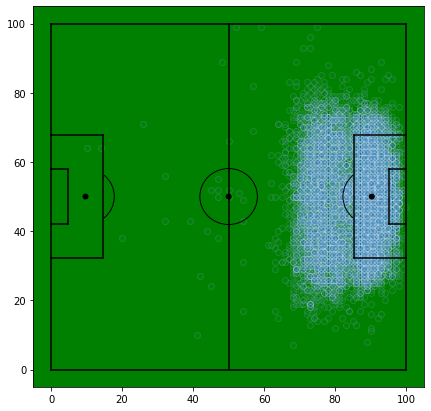

In [469]:
fig=plt.figure()
fig.set_size_inches(7, 7)
ax=fig.add_subplot(1,1,1)
draw_pitch(plt,ax)
plt.scatter(x=df[df['eventName']=='Shot']['event_location_x'],y=df[df['eventName']=='Shot']['event_location_y'],alpha=0.1,cmap='White',edgecolors='white')
plt.show()

---

---

#### Reminder of Key Point: x direction is from the perspective of the team attacking (with the ball), grows as you go closer to the opposing goal.

---

---

OK so, we now have a dataframe (df_Tplus1) where a score for something like goal, or other outcome metric refers to the previous action

It also has all the relevant input information for that particular action.

--- 

--- 

Adding in a field for home / away so we can create a running metric of xG for home / away teams

In [1149]:
#changing the match to a dictionary in the right format
new_match_dict = {}
for key, value in matches_df[['wyId','home_team_id','away_team_id']].reset_index().to_dict('index').items():
    new_match_dict[value['wyId']] = {value['home_team_id']: 1, value['away_team_id']: 0}

In [1150]:
df['home_1_away_0'] = df.apply(lambda x: new_match_dict[x.matchId][x.teamId],axis=1)

---

---

Section 2 - Creating xG shot model

In [ ]:
#First, need to create a new df which has goal in the same row as the shot when it's taken
df_xg = df.copy()
df_xg['Goal'] = df_xg['tags'].apply(lambda x: extract_tag(x,101))

In [ ]:
#just get the relevant shots
ev_filter = ['Shot','Free kick shot','Penalty']
events_df_train_shot_only_x = df_xg[df_xg['subEventName'].isin(ev_filter)][[
        'is_penalty', 'is_freekick', 'head/body', 'counter_attack',
       'opportunity', 'distance_to_goal',
       'angle_to_goal']]


In [ ]:
y = df_xg[df_xg['subEventName'].isin(ev_filter)]['Goal'].reset_index().drop(columns = 'index')
x_logit = sm.add_constant(events_df_train_shot_only_x).reset_index().drop(columns = 'index')
logit_model_basic = sm.Logit(y,x_logit).fit()
print(logit_model_basic.summary())

---

---

Perfect - this matches the xG model from before roughly

Now, need to plug this back in to the df so that each shot gives an xG value to the home or away team

In [ ]:
def predict_xG(subEventName,is_penalty, is_freekick, head_body, counter_attack, opportunity, distance_to_goal, angle_to_goal):
    if subEventName in (ev_filter):
        return logit_model_basic.predict(pd.DataFrame(data=[1, is_penalty, is_freekick, head_body, counter_attack, opportunity, distance_to_goal, angle_to_goal]).T)
    return 0

In [1151]:
df['xG_from_shot'] = df.apply(lambda x: predict_xG(x.subEventName,x.is_penalty, x.is_freekick, x['head/body'],x.counter_attack, x.opportunity,x.distance_to_goal,x.angle_to_goal),axis=1)

In [1152]:
df['xG_from_shot'] = df['xG_from_shot'].astype('float')
df['home_team_xG'] = df.apply(lambda x: x.home_1_away_0*x.xG_from_shot,axis=1)
df['away_team_xG'] = df.apply(lambda x: (1-x.home_1_away_0)*x.xG_from_shot,axis=1)

In [1153]:
df[df['subEventName'] == 'Shot'].head(1)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,is_penalty,is_freekick,counter_attack,Left,Right,head/body,direct,indirect,high,low,interception,clearance,opportunity,Feint,free_space_r,free_space_l,take_on_l,take_on_r,event_location_y,event_location_x,distance_to_goal,angle_to_goal_calc,angle_to_goal,outcome_event_location_y,outcome_event_location_x,outcome_distance_to_goal,outcome_angle_to_goal_calc,outcome_angle_to_goal,home_1_away_0,xG_from_shot,home_team_xG,away_team_xG
46,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,41,88,15.0,0.75,0.643501,50,100,0.0,NaN,NaN,1,0.170836,0.170836,0.0


---

---

#### Section 3 - MARKOV: ### We are creating 'target' values for a certain action, which we will run a model against to see if the other input actions and locations can predict this target value accurately

Here we create a value to every action which is the discounted value of shots coming shortly after it for their team.

First, we create a home_team and away_team discounted xG value

Then need to create the transition from home/away to team_with_possession/team_without_possession

Error handling: sometimes the markov values become much too large (>3) because they are factoring in multiple future shots. so an individual action is the max of it's shot value & the future value

In [ ]:
#### CREATES MARKOV VALUE

markov_df = df.copy()
markov_df['home_team_xG_markov'] = 0
markov_df['away_team_xG_markov'] = 0

In [ ]:
#create t plus 1 
# markov = R + gamma * v(t+1)
gamma = 0.9
for i in range(15):
    t_plus_1 = markov_df[1:].copy()
    t_plus_1 = t_plus_1.reset_index().drop(columns=['index'])
    t_plus_1.loc[len(t_plus_1)] = [0]*t_plus_1.shape[1]
    markov_df['home_team_xG_markov'] = pd.DataFrame({'shot_xg':markov_df['home_team_xG'],'future_xg':gamma*t_plus_1['home_team_xG_markov']}).astype('float').apply(lambda x: max(x.shot_xg,x.future_xg),axis=1)
    markov_df['away_team_xG_markov'] = pd.DataFrame({'shot_xg':markov_df['away_team_xG'],'future_xg':gamma*t_plus_1['away_team_xG_markov']}).astype('float').apply(lambda x: max(x.shot_xg,x.future_xg),axis=1)

In [ ]:
markov_df['players_team_xG_markov'] = (markov_df['home_1_away_0'] * markov_df['home_team_xG_markov'] + (1 - markov_df['home_1_away_0']) * markov_df['away_team_xG_markov']).astype('float')
markov_df['opp_team_xG_markov'] = (markov_df['home_1_away_0'] * markov_df['away_team_xG_markov'] + (1 - markov_df['home_1_away_0']) * markov_df['home_team_xG_markov']).astype('float')

In [515]:
#### TAKING A QUICK LOOK AT THE TOP AND BOTTOM VALUES

markov_df['home_team_xG_markov'].sort_values(ascending=True)[:]

408497    0.000000
528260    0.000000
528261    0.000000
528262    0.000000
528263    0.000000
            ...   
575367    0.803814
725592    0.803814
797179    0.803814
526209    0.803814
296395    0.819621
Name: home_team_xG_markov, Length: 816996, dtype: float64

In [516]:
##### TAKING A QUICK LOOK AT SOME EXAMPLES

# markov_df[75:78]

In [517]:
#### SAVING THE MODEL SO IT CAN BE USED WITHOUT LOADING ALL THE ABOVE

with open('saved_dfs/markov_df','w') as f:
    markov_df.to_csv(f)

In [518]:
## LOADING IT BACK IN
df_loaded = pd.read_csv('saved_dfs/markov_df')

ev_filter = ['Shot','Free kick shot','Penalty'] #this filter is used below so copied from above.

---

---

#### Section 3 - baseline linear regression

Methodology for markov analysis - xG based on the pass attempt, with the difference in xG of that versus the next action being the player's input

models:

a) Linear Regression (baseline)

b) run neural network by one hot encoding all sub evenets

c) try an attention model to look at some of the prior sequence information

d) RNN

e) supplement with action embeddings using word2vec - probably won't help because we have a lot of events already

overall - split the model in train/test by game. try and 'predict' the value of an action using the inputs, and then see how close to the 'true' value of those actions we get to on the validation set. 

Primary metric: R_squared on validation set

In [1138]:
#### DATA CLEANING AND PREPARATION - events_df has more columns than are needed for linear regression as some are used later

##NOTE: HAVE REMOVED OPPORTUNITY AND COUNTER ATTACK as these are not really observable
columns_of_interest = [
        'matchId',
        'subEventName',
       'head/body',
       'high', 'interception', 'Feint',
       'free_space_r', 'free_space_l', 'take_on_l', 'take_on_r',
       'distance_to_goal',
        'angle_to_goal',
        'outcome_distance_to_goal', 'outcome_angle_to_goal',
       'players_team_xG_markov', 'opp_team_xG_markov','home_1_away_0','event_location_y','outcome_event_location_y', 'event_location_x','outcome_event_location_x'
        ]

df_loaded1 = df_loaded[~df_loaded['subEventName'].isin(ev_filter)]
events_df_train_reduc = df_loaded1[columns_of_interest]

#replace NaN values in angle

#"""get dummies for subEventName"""
events_df_train_reduc = pd.get_dummies(events_df_train_reduc, columns = ['subEventName'])
event_df_train_reduc = events_df_train_reduc.fillna(0)

#"""train test split"""
set_of_unique_matches = tuple(set(matches_df['wyId']))
matches_id_train_set, matches_id_val_set = train_test_split(set_of_unique_matches,test_size=0.2, random_state=1)
events_df_train = events_df_train_reduc[events_df_train_reduc['matchId'].isin(matches_id_train_set)]
events_df_val = events_df_train_reduc[events_df_train_reduc['matchId'].isin(matches_id_val_set)]

---

---

Linear Regression

In [1141]:
np.mean(x_log[['event_location_y','event_location_x','distance_to_goal','angle_to_goal','outcome_distance_to_goal','outcome_angle_to_goal']])

event_location_y            26.798728
event_location_x            51.366024
distance_to_goal            61.284126
angle_to_goal               30.870805
outcome_distance_to_goal    57.758811
outcome_angle_to_goal       33.413221
dtype: float64

In [1187]:
x = events_df_train.drop(columns=['players_team_xG_markov','opp_team_xG_markov','matchId','home_1_away_0']) #'outcome_event_location_y','event_location_x','outcome_event_location_x','event_location_y'])
x_val = events_df_val.drop(columns=['players_team_xG_markov','opp_team_xG_markov','matchId','home_1_away_0']) #,'outcome_event_location_y','event_location_x','outcome_event_location_x','event_location_y'])
x_log = (x).reset_index().drop(columns=['index']).fillna(0)
x_log_v = (x_val).reset_index().drop(columns=['index']).fillna(0)

### For neural network, we need to make sure the input features are standardised around 1
#we're also going to keep in the model the event locations, normalised and also centred around the middle of the pitch for width.
def centre_ys_and_norm_locations(df):
    df[['event_location_y','outcome_event_location_y']] = (abs(50-df[['event_location_y','outcome_event_location_y']]))/100
    df[['event_location_x','outcome_event_location_x']] = (100-df[['event_location_x','outcome_event_location_x']]) / 100
    return df

x_log = centre_ys_and_norm_locations(x_log)
x_log_v = centre_ys_and_norm_locations(x_log_v)

def norm_continuous_cols(x_table):
    x_table[['distance_to_goal','angle_to_goal','outcome_distance_to_goal','outcome_angle_to_goal']] -= np.mean(x_table[['distance_to_goal','angle_to_goal','outcome_distance_to_goal','outcome_angle_to_goal']])
    x_table[['distance_to_goal','angle_to_goal','outcome_distance_to_goal','outcome_angle_to_goal']] /= np.std(x_table[['distance_to_goal','angle_to_goal','outcome_distance_to_goal','outcome_angle_to_goal']])
    return x_table
x_log_norm_train = norm_continuous_cols(x_log.copy())
x_log_norm_val = norm_continuous_cols(x_log_v.copy())
    
y1 = events_df_train['players_team_xG_markov'].reset_index().drop(columns=['index'])
y1_val = events_df_val['players_team_xG_markov'].reset_index().drop(columns=['index'])

In [1045]:
x_threat = sm.OLS(y1, x_log_norm_train,hasconst=False).fit()
print(x_threat.summary())

                                   OLS Regression Results                                  
Dep. Variable:     players_team_xG_markov   R-squared (uncentered):                   0.103
Model:                                OLS   Adj. R-squared (uncentered):              0.103
Method:                     Least Squares   F-statistic:                              1615.
Date:                    Fri, 17 Sep 2021   Prob (F-statistic):                        0.00
Time:                            10:43:26   Log-Likelihood:                      1.3571e+06
No. Observations:                  634988   AIC:                                 -2.714e+06
Df Residuals:                      634943   BIC:                                 -2.714e+06
Df Model:                              45                                                  
Covariance Type:                nonrobust                                                  
                                          coef    std err          t      P>|t| 

In [1046]:
### TESTING SIMILAR ON VAL SET

In [1047]:
from sklearn.metrics import r2_score

In [1048]:
def print_r_scores(model, y_train, y_val, x_train, x_val):
    outputs_train = model.predict(x_train)
    outputs_val = model.predict(x_val)
    print(f'MODEL R2 SCORE IS')
    print(f'VAL: {round(r2_score(y_val, outputs_val),4)}\nTRAIN: {round(r2_score(y_train,outputs_train),4)}')

print_r_scores(x_threat, y1, y1_val, x_log_norm_train, x_log_norm_val)    

MODEL R2 SCORE IS
VAL: 0.058
TRAIN: 0.0573


---

Removing low P values

In [1049]:
### REMOVING LOW P VALUES
removed_cols = ['head/body','subEventName_Goal kick, subEventName_Ground defending duel','subEventName_Hand foul',
'subEventName_Launch','subEventName_Simulation','subEventName_Time lost foul','subEventName_Violent Foul','subEventName_Whistle']
column_names = x_log_norm_val.columns
new_cols = [x for x in column_names if x not in removed_cols]
x_train_removed_low_coefs = x_log_norm_train[new_cols]
x_val_removed_low_coefs = x_log_norm_val[new_cols]

In [1050]:
x_threat1 = sm.OLS(y1, x_train_removed_low_coefs,hasconst=False).fit()
print(x_threat1.summary())
print_r_scores(x_threat1, y1, y1_val, x_train_removed_low_coefs, x_val_removed_low_coefs)    

                                   OLS Regression Results                                  
Dep. Variable:     players_team_xG_markov   R-squared (uncentered):                   0.101
Model:                                OLS   Adj. R-squared (uncentered):              0.101
Method:                     Least Squares   F-statistic:                              1885.
Date:                    Fri, 17 Sep 2021   Prob (F-statistic):                        0.00
Time:                            10:43:27   Log-Likelihood:                      1.3567e+06
No. Observations:                  634988   AIC:                                 -2.713e+06
Df Residuals:                      634950   BIC:                                 -2.713e+06
Df Model:                              38                                                  
Covariance Type:                nonrobust                                                  
                                          coef    std err          t      P>|t| 

---

Looking at some values if we append these predictions to the end of the dataframe

In [1051]:
preds_val_in_df = pd.DataFrame(outputs1)
df_showing_val_results = events_df_val.copy().reset_index()
df_showing_val_results['predicted_x_threat'] = preds_val_in_df

In [1052]:
#### THIS SHOWS HOW OUTCOME DISTANCE TO GOAL POSITIVELY AFFECTS THE PREDICTED X_THREAT

# df_showing_val_results[308:313]

OK, so we're getting +5% predictive capacity versus completely randomness from a logistic regression model and they make sense when matched up

---

---

#### Section 3.2: Dense Neural Network

The distribution of goals follows an exponential distribution: see below 

However, it turns out the sigmoid function captures the output better than a pure exponential function

[]

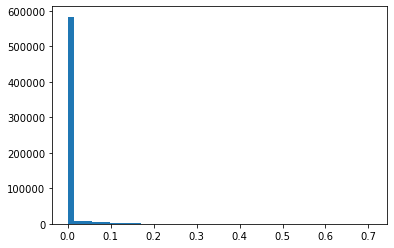

In [1053]:
plt.hist(y1,bins=50);plt.plot()

In [1301]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model, Input 
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Dense, Dropout
import matplotlib.pyplot as plt

In [1302]:
model = models.Sequential()
#Create input layer
model.add(layers.InputLayer(input_shape=(45)))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(96,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.RMSprop(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,400,600,1000],[0.002,0.001,0.0003,0.0001,0.00003])))

In [1303]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_415 (Dense)            (None, 100)               4600      
_________________________________________________________________
dense_416 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_417 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_418 (Dense)            (None, 96)                9696      
_________________________________________________________________
dense_419 (Dense)            (None, 1)                 97        
Total params: 34,593
Trainable params: 34,593
Non-trainable params: 0
_________________________________________________________________


In [1304]:

model.fit(x=x_log_norm_train,y=y1,batch_size=2000,epochs=10,validation_split=0.2)
model.fit(x=x_log_norm_train,y=y1,batch_size=5000,epochs=5,validation_split=0.2)
print_r_scores(model,y1,y1_val, x_log_norm_train, x_log_norm_val)

Epoch 1/10
254/254 [==============================] - 11s 7ms/step - loss: 0.0094 - val_loss: 9.3255e-04
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 7.5603e-04 - val_loss: 9.0482e-04
Epoch 3/10
254/254 [==============================] - 1s 6ms/step - loss: 7.4070e-04 - val_loss: 9.0477e-04
Epoch 4/10
254/254 [==============================] - 1s 6ms/step - loss: 7.4957e-04 - val_loss: 9.0511e-04
Epoch 5/10
254/254 [==============================] - 1s 6ms/step - loss: 7.3758e-04 - val_loss: 9.0514e-04
Epoch 6/10
254/254 [==============================] - 1s 6ms/step - loss: 7.3745e-04 - val_loss: 9.0495e-04
Epoch 7/10
254/254 [==============================] - 1s 6ms/step - loss: 7.4730e-04 - val_loss: 9.0427e-04
Epoch 8/10
254/254 [==============================] - 1s 6ms/step - loss: 7.4010e-04 - val_loss: 9.0453e-04
Epoch 9/10
254/254 [==============================] - 1s 6ms/step - loss: 7.2368e-04 - val_loss: 9.0422e-04
Epoch 10/10
254/254 [==========

---

---

Now up to 11.26% on the validation set, significantly higher than Logistic Regression

### Section 4: sequence models

4.1: Attention model

--- --- 

Data prep

We need to create a sequence model, where each example also contains the past 5 events in the sequence.

Other changes:
 - using raw event_location data
 - add positional encoding for attention model.
 - re-calculate distances relative to the perspective of the last player in the sequence

In [1181]:
"""
In: events_df_train with all the columns
Processes:
 drops previously created columns of angle/distnace to goal in favour of raw event_location data
 gets the absolute value of the y (width) value)
 makes all the event location values between 0 and 1
"""
df_train_for_attn = events_df_train.drop(columns =['matchId','outcome_distance_to_goal','outcome_angle_to_goal','distance_to_goal','angle_to_goal'])
df_val_for_attn = events_df_val.drop(columns =['matchId','outcome_distance_to_goal','outcome_angle_to_goal','distance_to_goal','angle_to_goal'])
#change all the event outcome locations to abs(50-y)
def centre_ys_and_standardise_both(df):
    df[['event_location_y','outcome_event_location_y']] = (abs(50-df[['event_location_y','outcome_event_location_y']]))/100
    df[['event_location_x','outcome_event_location_x']] = df[['event_location_x','outcome_event_location_x']] / 100
    return df

df_train_for_attn = centre_ys_and_standardise_both(df_train_for_attn)
df_val_for_attn = centre_ys_and_standardise_both(df_val_for_attn)

In [1251]:
def create_sequences(N, dataframe):
    """
    In: takes the dataframe from above
    Axis 3 is the time series and t=N is the last action in the sequence, which is the one we want to predict
    Out: rows which have an axis (t) with the proceeding events
    """
    x_array = np.array(dataframe)
    x_array_with_T = np.zeros((x_array.shape[0],x_array.shape[1],N))
    
    for n in range(N):
        x_temp = x_array.copy()
        x_temp = x_temp[n:]
        if n!= 0:
            blank_rows = np.zeros((n,x_temp.shape[1]))
            x_temp = np.append(x_temp,blank_rows,axis=0)
        x_array_with_T[:,:,n] = x_temp
    return x_array_with_T[:-N+1,:,:]

N = 6
x_train_with_T = create_sequences(N, df_train_for_attn)
x_val_with_T = create_sequences(N, df_val_for_attn)

In [1252]:
def perspective(df_train_for_attn, x_train_with_T):

    """
    Puts everything in perspective of the final player in the sequence
    In: takes the array above with the sequence
    Processes:
     1- creates a column(-2) which is the home/away value of the final team in the sequence
     2- creates a column(-1) which is whether that particular event was an event for the final team or the opposing team
     3- changes the event_location x and outcome event_location x to the distance frm the opposition goal of the final team in the sequence (replaces previous columns)
     4- create outcome distance to goal and angle to goal
     5- takes x_for_mod which is just the x_values (removes player_xg, opp_xg, home_away_1 and the newly created "final team in sequence") and y_player_xg with the player team markov values
     
     """

    ### PROCESS 1 create 45th column which represents the final team that has the ball's home_away index, and have that N times
    home_way_index =list(df_train_for_attn.columns).index('home_1_away_0')
    ha_final_step = np.zeros((x_train_with_T.shape[0],1,N))
    for i in range(N):
        ha_final_step[:,0,i] = x_train_with_T[:,home_way_index,5]
    x_train_with_T = np.append(x_train_with_T,ha_final_step,axis=1)
    
    ### PROCESS 2 now create a 46th column which = Ax + (1-A)(1-x) where A is whether or not we're the action at time n is an action fo the players team or the opposing team
    players_perspective_possession = np.expand_dims(x_train_with_T[:,x_train_with_T.shape[1]-1,:]* x_train_with_T[:,home_way_index,:] + (1-x_train_with_T[:,x_train_with_T.shape[1]-1,:]) * (1-x_train_with_T[:,home_way_index,:]),axis=1)
    x_train_with_T = np.append(x_train_with_T, players_perspective_possession,axis=1)

    ########## KEY TAKEAWAY - FINAL COLUMN REPRESENTS WHETHER OR NOT THIS ACTION WAS ORIGINALLY FROM THE PERSPECTIVE OF THE FINAL PLAYER WHO HAD THE FINAL ACTION.

    ### PROCESS 3: if final column is 1, event locations x are the normal 1-x), otherwise they are x
    event_x =list(df_train_for_attn.columns).index('event_location_x')
    out_event_x =list(df_train_for_attn.columns).index('outcome_event_location_x')
    player_perspective_event_dist = x_train_with_T[:,-1,:] * (1-x_train_with_T[:,event_x,:]) + ((1-x_train_with_T[:,-1,:]) * x_train_with_T[:,event_x,:])
    player_persp_Outevent_dist = x_train_with_T[:,-1,:] * (1-x_train_with_T[:,out_event_x,:]) + ((1-x_train_with_T[:,-1,:]) * x_train_with_T[:,out_event_x,:])
    x_train_with_T[:,event_x,:] = player_perspective_event_dist
    x_train_with_T[:,out_event_x,:] = player_persp_Outevent_dist
    
    ### PROCESS 4: create distance and angle to goal
    event_y_key = list(df_train_for_attn.columns).index('event_location_y')
    outcome_y_key = list(df_train_for_attn.columns).index('outcome_event_location_y')
    
    def append_dist_angle(x_train_with_T, event_x, event_y_key):
        distance_to_goal = np.expand_dims(np.sqrt(x_train_with_T[:,event_x,:]**2 + x_train_with_T[:,event_y_key,:]**2),axis=1)
        distance_to_goal -= np.mean(distance_to_goal[:,:,N-1]); distance_to_goal /= np.std(distance_to_goal[:,:,N-1])        
        angle_to_goal = np.expand_dims((np.arctan(x_train_with_T[:,event_y_key,:] / (x_train_with_T[:,event_x,:]+1e-10)))*180 / np.pi,axis=1) #normalizes it
        angle_to_goal -= np.mean(angle_to_goal[:,:,N-1]); angle_to_goal /= np.std(angle_to_goal[:,:,N-1])        
        dist_angle = np.append(distance_to_goal,angle_to_goal,axis=1)
        x_train_with_T = np.append(x_train_with_T,dist_angle,axis=1)#at the beginning because will want to remove the last column
        return x_train_with_T
    x_train_with_T = append_dist_angle(x_train_with_T,out_event_x, outcome_y_key)
    x_train_with_T = append_dist_angle(x_train_with_T,event_x, event_y_key)
    
    ### PROCESS 5: get players_team value and opp_team_value
    players_xg_key = list(df_train_for_attn.columns).index('players_team_xG_markov')
    opp_xg_key = list(df_train_for_attn.columns).index('opp_team_xG_markov')
    cols_to_keep = list(range(0,players_xg_key))+list(range(opp_xg_key+2,x_train_with_T.shape[1]))
    x_for_mod = x_train_with_T[:,cols_to_keep,:] #the +2 also drops the home/away column and the second last 2 columns is also dropped
    y_player_xg = x_train_with_T[:,[players_xg_key],N-1]
    return x_for_mod, y_player_xg, x_train_with_T

x_with_adjustments_train, y_player_xg, x_train_with_T_chg = perspective(df_train_for_attn, x_train_with_T)
x_with_adjustments_val, y_player_xg_val, x_val_with_T_chg = perspective(df_val_for_attn, x_val_with_T)

In [1253]:
#####CHECKING THAT THE ANGLE / DIST COLUMNS ETC WORK

# event_x =list(df_train_for_attn.columns).index('event_location_x')
# event_y =list(df_train_for_attn.columns).index('event_location_y')
# outcome_x =list(df_train_for_attn.columns).index('outcome_event_location_x')
# outcome_y =list(df_train_for_attn.columns).index('outcome_event_location_y')

# print(x_train_with_T[:10,[outcome_x,outcome_y,event_x,event_y],0])
# print(x_for_mod[:10,[outcome_x-3,outcome_y-3,event_x-3, event_y-3],0])
# print(x_for_mod[:10,-4:,0])
# display(df_train_for_attn[:10]) 


In [1254]:
"""
In: previous arrays

Out: removes the column which is all 1s or all 0s
transposed into the shape required for sequence model
"""
x_for_mod = np.delete(x_with_adjustments_train,x_with_adjustments_train.shape[1]-6,axis=1)
x_for_mod_val = np.delete(x_with_adjustments_val,x_with_adjustments_train.shape[1]-6,axis=1)
x_for_mod = x_for_mod.transpose(0,2,1)
x_for_mod_val = x_for_mod_val.transpose(0,2,1)
x_for_mod.shape, x_for_mod_val.shape

((634983, 6, 46), (170217, 6, 46))

In [1257]:
pd.DataFrame(data=(x_for_mod.transpose(0,2,1)[:,:,5]))[-5:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
634978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.30,0.65,0.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.179519,-0.199133,0.992052,0.318990
634979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.30,0.44,0.54,0.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.040599,0.790230,0.023445,-0.086508
634980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.48,0.36,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.290385,1.646071,-0.212245,0.944906
634981,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48,0.50,0.18,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.346901,2.585182,-0.479702,1.837124
634982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.50,0.86,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.416406,-0.312869,1.196874,-1.248671


In [1258]:
x_log_norm_train[-5:]

,head/body,high,interception,Feint,free_space_r,free_space_l,take_on_l,take_on_r,distance_to_goal,angle_to_goal,outcome_distance_to_goal,outcome_angle_to_goal,event_location_y,outcome_event_location_y,event_location_x,outcome_event_location_x,subEventName_Acceleration,subEventName_Air duel,subEventName_Ball out of the field,subEventName_Clearance,subEventName_Corner,subEventName_Cross,subEventName_Foul,subEventName_Free Kick,subEventName_Free kick cross,subEventName_Goal kick,subEventName_Ground attacking duel,subEventName_Ground defending duel,subEventName_Ground loose ball duel,subEventName_Hand foul,subEventName_Hand pass,subEventName_Head pass,subEventName_High pass,subEventName_Late card foul,subEventName_Launch,subEventName_Out of game foul,subEventName_Protest,subEventName_Simple pass,subEventName_Simulation,subEventName_Smart pass,subEventName_Throw in,subEventName_Time lost foul,subEventName_Touch,subEventName_Violent Foul,subEventName_Whistle
634983,0,0,0,0,0,0,0,0,0.992052,0.318997,0.179515,-0.199125,0.50,0.30,0.65,0.54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
634984,0,0,0,0,0,0,0,0,0.023442,-0.086501,-0.040604,0.790237,0.30,0.44,0.54,0.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
634985,0,0,0,0,0,0,0,0,-0.212249,0.944913,-0.290391,1.646078,0.44,0.48,0.36,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
634986,0,1,0,0,0,0,0,0,-0.479706,1.837131,-0.346907,2.585189,0.48,0.50,0.18,0.00,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
634987,0,0,0,0,0,0,0,0,1.196874,-1.248664,2.416406,-0.312861,0.07,0.50,0.86,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [754]:
#add positional embedding
def get_angles(pos, i, d_model):
    """position and i are row and column vectors, respectively, d_model is a value (same value as the number of rows in i)
    Out: pos x i dimension matrix
    """
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    """
    In: the matrix created by the pos and d_model vectors, which are evently spaced out integers.
    Out: sin for even numbers, cos for odd numbers
    """
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [905]:
n,d = x_for_mod_val.shape[2], N
pos_embeddings = np.array(positional_encoding(n,d)).transpose(0,2,1)

In [906]:
print(x_for_mod.shape)
pos_embeddings.shape

(634982, 6, 46)


(1, 6, 46)

---

---

#### 4.2 Trying the attention model

In [1341]:
class Attention_Model():
    def __init__(self,pos_embeddings,N,x_for_mod):
        self.x_input = Input(shape=(N,x_for_mod.shape[2]))
        x = tf.keras.layers.Add()([self.x_input,pos_embeddings])
        x_mha = tf.keras.layers.MultiHeadAttention(num_heads=8,key_dim=30, value_dim= 50)(x,x)
        x = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([x,x_mha]))
        x = tf.keras.layers.MultiHeadAttention(num_heads=8,key_dim=30, value_dim= 50, output_shape= 80)(x,x)
        x = tf.keras.layers.LayerNormalization()(x) #(tf.keras.layers.Add()([x_mha]))
        x = tf.keras.layers.Lambda(lambda x: x[:,-1])(x)
        x = Dense(100,activation='relu')(x)
        x = Dense(100,activation='relu')(x)
        x = Dense(100,activation='relu')(x)
        x = Dense(96,activation='relu')(x)
        x = Dense(1,activation = 'sigmoid')(x)
        self.model = Model(inputs = self.x_input, outputs= x)                         

In [1342]:
attention_mod = Attention_Model(pos_embeddings,N,x_for_mod)

In [1343]:
attention_mod.model.summary()

Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_126 (InputLayer)          [(None, 6, 46)]      0                                            
__________________________________________________________________________________________________
add_42 (Add)                    (None, 6, 46)        0           input_126[0][0]                  
__________________________________________________________________________________________________
multi_head_attention_34 (MultiH (None, 6, 46)        59806       add_42[0][0]                     
                                                                 add_42[0][0]                     
__________________________________________________________________________________________________
add_43 (Add)                    (None, 6, 46)        0           add_42[0][0]              

In [1344]:
optim = tf.keras.optimizers.RMSprop(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,400,600,1000],[0.002,0.001,0.0003,0.0001,0.00001]))
attention_mod.model.compile(loss='mean_squared_error',optimizer=optim)
attention_mod.model.fit(x=x_for_mod,y=y_player_xg,batch_size=1000,epochs=8,validation_split=0.2)
attention_mod.model.fit(x=x_for_mod,y=y_player_xg,batch_size=2500,epochs=10,validation_split=0.2)
attention_mod.model.fit(x=x_for_mod,y=y_player_xg,batch_size=5000,epochs=5,validation_split=0.2)
print_r_scores(attention_mod.model,y_player_xg,y_player_xg_val,x_for_mod,x_for_mod_val)

Epoch 1/8
508/508 [==============================] - 101s 195ms/step - loss: 0.0039 - val_loss: 9.2859e-04
Epoch 2/8
508/508 [==============================] - 116s 228ms/step - loss: 7.5871e-04 - val_loss: 9.1351e-04
Epoch 3/8
508/508 [==============================] - 121s 239ms/step - loss: 7.4645e-04 - val_loss: 9.1135e-04
Epoch 4/8
508/508 [==============================] - 127s 250ms/step - loss: 7.2996e-04 - val_loss: 9.1040e-04
Epoch 5/8
508/508 [==============================] - 130s 255ms/step - loss: 7.3426e-04 - val_loss: 9.0896e-04
Epoch 6/8
508/508 [==============================] - 128s 252ms/step - loss: 7.2795e-04 - val_loss: 9.0905e-04
Epoch 7/8
508/508 [==============================] - 122s 240ms/step - loss: 7.2847e-04 - val_loss: 9.0860e-04
Epoch 8/8
508/508 [==============================] - 119s 235ms/step - loss: 7.5381e-04 - val_loss: 9.0806e-04
Epoch 1/10
204/204 [==============================] - 116s 568ms/step - loss: 7.3985e-04 - val_loss: 9.0948e-04
Epoc

##### Possible issues

-- sequence not long enough

--- attention needs large amounts of data

-- does the positional encoding help

---
##### Some basic checks, using a log res to see if it works for log res and whether the bulk of low p values are on the last sequence

In [211]:
### quick look at means of each of the columns

pd.DataFrame(index=list(df_train_for_attn.columns[(list(range(0,8))+list(range(11,df_train_for_attn.shape[1])))]),data=np.mean(x_for_mod,axis=(0,1))).T

,head/body,high,interception,Feint,free_space_r,free_space_l,take_on_l,take_on_r,event_location_y,outcome_event_location_y,event_location_x,outcome_event_location_x,subEventName_Acceleration,subEventName_Air duel,subEventName_Ball out of the field,subEventName_Clearance,subEventName_Corner,subEventName_Cross,subEventName_Foul,subEventName_Free Kick,subEventName_Free kick cross,subEventName_Goal kick,subEventName_Ground attacking duel,subEventName_Ground defending duel,subEventName_Ground loose ball duel,subEventName_Hand foul,subEventName_Hand pass,subEventName_Head pass,subEventName_High pass,subEventName_Late card foul,subEventName_Launch,subEventName_Out of game foul,subEventName_Protest,subEventName_Simple pass,subEventName_Simulation,subEventName_Smart pass,subEventName_Throw in,subEventName_Time lost foul,subEventName_Touch,subEventName_Violent Foul,subEventName_Whistle
0,0.000038,0.018778,0.056056,0.000602,0.019983,0.019988,0.014764,0.014737,0.535974,0.544555,0.507086,0.503142,0.007973,0.060044,0.034336,0.019191,0.006232,0.019816,0.012855,0.011578,0.002759,0.010092,0.085306,0.084627,0.049136,0.000528,0.004216,0.034018,0.04025,0.000094,0.015909,0.000142,0.000146,0.407154,0.000039,0.009622,0.027251,0.000074,0.05393,0.000033,0.000257


In [917]:
##### Run a log res on the flattened xarray, hope to see that the latter variables are the ones that are significant (as they are the actual event in questions)

flat_seq_x_train = x_for_mod.reshape(x_for_mod.shape[0],-1)
flat_seq_x_val = x_for_mod_val.reshape(x_for_mod_val.shape[0],-1)
log_res_check = sm.OLS(y_player_xg,exog=flat_seq_x_train).fit()
# print(log_res_check.summary())
print_r_scores(log_res_check, y_player_xg, y_player_xg_val, flat_seq_x_train, flat_seq_x_val)

MODEL R2 SCORE IS
VAL: 0.0627
TRAIN: 0.063


---
OK it works - print the log_res_check summary for proof - the final coefficients all seem to matter the most

---

---

#### 4.3 Trying an RNN / GRU

In [918]:
class Simple_RNN():
    def __init__(self,x_for_mod):
        self.input_im = Input(shape=(N,x_for_mod.shape[2]))
        x = tf.keras.layers.SimpleRNN(120,activation = 'tanh',kernel_initializer='glorot_uniform')(self.input_im)
        x = Dense(100,activation='relu')(x)
        x = Dense(100,activation='relu')(x)
        x = Dense(100,activation='relu')(x)
        x = Dense(96,activation='relu')(x)    
        x = Dense(1,activation = 'sigmoid')(x)
        self.model = Model(inputs = self.input_im, outputs= x)  

In [1345]:
simple_rnn = Simple_RNN(x_for_mod)


In [1346]:
simple_rnn.model.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_127 (InputLayer)       [(None, 6, 46)]           0         
_________________________________________________________________
simple_rnn_34 (SimpleRNN)    (None, 120)               20040     
_________________________________________________________________
dense_457 (Dense)            (None, 100)               12100     
_________________________________________________________________
dense_458 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_459 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_460 (Dense)            (None, 96)                9696      
_________________________________________________________________
dense_461 (Dense)            (None, 1)                 97 

In [1347]:
optim = tf.keras.optimizers.RMSprop(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,400,600,1000],[0.002,0.001,0.0003,0.0001,0.00001]))
simple_rnn.model.compile(loss='mean_squared_error',optimizer=optim)

In [1348]:
simple_rnn.model.fit(x=x_for_mod,y=y_player_xg,batch_size=2500,epochs=5,validation_split=0.2)
simple_rnn.model.fit(x=x_for_mod,y=y_player_xg,batch_size=5000,epochs=5,validation_split=0.2)
print_r_scores(simple_rnn.model,y_player_xg, y_player_xg_val, x_for_mod, x_for_mod_val)

Epoch 1/5
204/204 [==============================] - 11s 44ms/step - loss: 0.0099 - val_loss: 0.0011
Epoch 2/5
204/204 [==============================] - 9s 46ms/step - loss: 8.6936e-04 - val_loss: 9.1643e-04
Epoch 3/5
204/204 [==============================] - 10s 51ms/step - loss: 7.4556e-04 - val_loss: 9.1106e-04
Epoch 4/5
204/204 [==============================] - 10s 49ms/step - loss: 7.3405e-04 - val_loss: 9.0704e-04
Epoch 5/5
204/204 [==============================] - 9s 43ms/step - loss: 7.4361e-04 - val_loss: 9.0724e-04
Epoch 1/5
102/102 [==============================] - 8s 80ms/step - loss: 7.3271e-04 - val_loss: 9.0648e-04
Epoch 2/5
102/102 [==============================] - 9s 88ms/step - loss: 7.3241e-04 - val_loss: 9.0645e-04
Epoch 3/5
102/102 [==============================] - 10s 94ms/step - loss: 7.3218e-04 - val_loss: 9.0615e-04
Epoch 4/5
102/102 [==============================] - 9s 86ms/step - loss: 7.3205e-04 - val_loss: 9.0631e-04
Epoch 5/5
102/102 [=============

#### Slightly Worse performance than without

GRU

In [1349]:
class GRU():
    def __init__(self,x_for_mod):
        self.input_im = Input(shape=(N,x_for_mod.shape[2]))
        x = tf.keras.layers.GRU(120,activation = 'tanh')(self.input_im)
        x = Dense(100,activation='relu')(x)
        x = Dense(100,activation='relu')(x)
        x = Dense(100,activation='relu')(x)
        x = Dense(96,activation='relu')(x)    
        x = Dense(1,activation = 'sigmoid')(x)
        self.model = Model(inputs = self.input_im, outputs= x)  

In [1350]:
gru = GRU(x_for_mod)
gru.model.summary()
gru.model.compile(loss='mean_squared_error',optimizer=optim)

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_128 (InputLayer)       [(None, 6, 46)]           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 120)               60480     
_________________________________________________________________
dense_462 (Dense)            (None, 100)               12100     
_________________________________________________________________
dense_463 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_464 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_465 (Dense)            (None, 96)                9696      
_________________________________________________________________
dense_466 (Dense)            (None, 1)                 97 

In [1351]:
optim = tf.keras.optimizers.RMSprop(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,400,600,1000],[0.002,0.001,0.0003,0.0001,0.00001]))
gru.model.fit(x=x_for_mod,y=y_player_xg,batch_size=2000,epochs=18,validation_split=0.2)
gru.model.fit(x=x_for_mod,y=y_player_xg,batch_size=10000,epochs=5,validation_split=0.2)
print_r_scores(gru.model,y_player_xg, y_player_xg_val, x_for_mod, x_for_mod_val)

Epoch 1/18
254/254 [==============================] - 33s 118ms/step - loss: 0.2383 - val_loss: 0.1940
Epoch 2/18
254/254 [==============================] - 26s 101ms/step - loss: 0.1752 - val_loss: 0.1111
Epoch 3/18
254/254 [==============================] - 33s 132ms/step - loss: 0.0905 - val_loss: 0.0332
Epoch 4/18
254/254 [==============================] - 35s 138ms/step - loss: 0.0228 - val_loss: 0.0034
Epoch 5/18
254/254 [==============================] - 33s 132ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 6/18
254/254 [==============================] - 36s 141ms/step - loss: 8.3269e-04 - val_loss: 9.7389e-04
Epoch 7/18
254/254 [==============================] - 33s 132ms/step - loss: 8.0250e-04 - val_loss: 9.5499e-04
Epoch 8/18
254/254 [==============================] - 35s 136ms/step - loss: 7.8143e-04 - val_loss: 9.4362e-04
Epoch 9/18
254/254 [==============================] - 38s 150ms/step - loss: 7.7550e-04 - val_loss: 9.3610e-04
Epoch 10/18
254/254 [====================

----

----

#### 4.4 NNs

Neural network with sequenced data

In [1337]:
flat_seq_x_train = x_for_mod.reshape(x_for_mod.shape[0],-1)
flat_seq_x_val = x_for_mod_val.reshape(x_for_mod_val.shape[0],-1)

In [1338]:
model_seq = models.Sequential()
#Create input layer
model_seq.add(layers.InputLayer(input_shape=(flat_seq_x_train.shape[1])))
model_seq.add(Dense(200,activation='relu'))
model_seq.add(Dense(200,activation='relu'))
model_seq.add(Dense(180,activation='relu'))
model_seq.add(Dense(100,activation='relu'))
model_seq.add(Dense(100,activation='relu'))
model_seq.add(Dense(96,activation='relu'))
model_seq.add(Dense(1,activation='sigmoid'))
model_seq.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.RMSprop(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,400,600,1000],[0.002,0.001,0.0003,0.0001,0.00003])))


In [1339]:
model_seq.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_445 (Dense)            (None, 200)               55400     
_________________________________________________________________
dense_446 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_447 (Dense)            (None, 180)               36180     
_________________________________________________________________
dense_448 (Dense)            (None, 100)               18100     
_________________________________________________________________
dense_449 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_450 (Dense)            (None, 96)                9696      
_________________________________________________________________
dense_451 (Dense)            (None, 1)               

In [1340]:
model_seq.fit(x=flat_seq_x_train,y=y_player_xg,batch_size=2000,epochs=15,validation_split=0.2)
model_seq.fit(x=flat_seq_x_train,y=y_player_xg,batch_size=5000,epochs=5,validation_split=0.2)
print_r_scores(model_seq,y_player_xg, y_player_xg_val,flat_seq_x_train,flat_seq_x_val)


Epoch 1/15
254/254 [==============================] - 5s 15ms/step - loss: 0.0086 - val_loss: 9.7546e-04
Epoch 2/15
254/254 [==============================] - 3s 14ms/step - loss: 8.1792e-04 - val_loss: 9.1519e-04
Epoch 3/15
254/254 [==============================] - 4s 14ms/step - loss: 7.3912e-04 - val_loss: 9.1283e-04
Epoch 4/15
254/254 [==============================] - 3s 14ms/step - loss: 7.3726e-04 - val_loss: 9.1262e-04
Epoch 5/15
254/254 [==============================] - 3s 14ms/step - loss: 7.3535e-04 - val_loss: 9.1191e-04
Epoch 6/15
254/254 [==============================] - 4s 14ms/step - loss: 7.4301e-04 - val_loss: 9.1146e-04
Epoch 7/15
254/254 [==============================] - 4s 14ms/step - loss: 7.2366e-04 - val_loss: 9.1016e-04
Epoch 8/15
254/254 [==============================] - 4s 14ms/step - loss: 7.2614e-04 - val_loss: 9.1010e-04
Epoch 9/15
254/254 [==============================] - 4s 14ms/step - loss: 7.4020e-04 - val_loss: 9.1011e-04
Epoch 10/15
254/254 [==

---

---

---
#### Quick Check that the numpy stuff hasn't made a difference.

Just take the last in the sequence, which should be equivalent completely

First - check that the differences are negligible, and then that the model works

In [1333]:
order = list(range(0,8)) + [44,45,42,43,8,9,10,11] + list(range(12,41))
x_check_train, x_check_val = x_for_mod[:,-1,:], x_for_mod_val[:,-1,:]
x_check_train = np.array(pd.DataFrame(x_check_train).drop(columns=[41])[order])
x_check_val = np.array(pd.DataFrame(x_check_val).drop(columns=[41])[order])

In [1334]:
y1.shape, y_moins_6_train.shape

((634988, 1), (634983, 1))

In [1336]:
print(np.max(np.array(y1[5:]) - y_player_xg))
np.max(np.array(x_log_norm_train[5:]) - x_check_train[:])

0.0


8.43567799901912e-06

In [1309]:
model_check = models.Sequential()
#Create input layer
model_check.add(layers.InputLayer(input_shape=(45)))
model_check.add(Dense(100,activation='relu'))
model_check.add(Dense(100,activation='relu'))
model_check.add(Dense(100,activation='relu'))
model_check.add(Dense(96,activation='relu'))
model_check.add(Dense(1,activation='sigmoid'))
model_check.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.RMSprop(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,400,600,1000],[0.002,0.001,0.0003,0.0001,0.00003])))

model_check.fit(x=x_check_train,y=y_player_xg,batch_size=2000,epochs=10,validation_split=0.2)
model_check.fit(x=x_check_train,y=y_player_xg,batch_size=5000,epochs=5,validation_split=0.2)
print_r_scores(model_check,y_player_xg,y_player_xg_val, x_check_train, x_check_val)

Epoch 1/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0080 - val_loss: 9.2066e-04
Epoch 2/10
254/254 [==============================] - 1s 6ms/step - loss: 7.5899e-04 - val_loss: 9.0403e-04
Epoch 3/10
254/254 [==============================] - 1s 5ms/step - loss: 7.2650e-04 - val_loss: 9.0571e-04
Epoch 4/10
254/254 [==============================] - 1s 5ms/step - loss: 7.2891e-04 - val_loss: 9.0474e-04
Epoch 5/10
254/254 [==============================] - 1s 6ms/step - loss: 7.4440e-04 - val_loss: 9.0388e-04
Epoch 6/10
254/254 [==============================] - 1s 5ms/step - loss: 7.4167e-04 - val_loss: 9.0448e-04
Epoch 7/10
254/254 [==============================] - 1s 5ms/step - loss: 7.3558e-04 - val_loss: 9.0355e-04
Epoch 8/10
254/254 [==============================] - 1s 6ms/step - loss: 7.2697e-04 - val_loss: 9.0442e-04
Epoch 9/10
254/254 [==============================] - 1s 6ms/step - loss: 7.4173e-04 - val_loss: 9.0400e-04
Epoch 10/10
254/254 [===========

---

---

### Conclusion: there's not enough information in previous time steps to inform the x_threat of a particular action

#### 5. Potential improvements

- l1 reg - significantly worse

- wider model - no improvement

- deeper model - significantly worse

- tanh activaiton - same

- lambda activation function cap sigmoid between 0 and 0.15; tiny increase to 11.34

In [1377]:
model = models.Sequential()
#Create input layer
kern_reg = tf.keras.regularizers.l1(l1=kern_reg_factor)
bias_reg = tf.keras.regularizers.l1(l1=bias_reg_factor)
model.add(layers.InputLayer(input_shape=(45)))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(96,activation='relu'))
model.add(Dense(1))
model.add(tf.keras.layers.Lambda(lambda x: 0.15/(1+tf.exp(-x))))

model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.RMSprop(learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay([200,600,1200,2000],[0.003,0.001,0.0003,0.0001,0.00003])))
model.fit(x=x_log_norm_train,y=y1,batch_size=1000,epochs=20,validation_split=0.2)
model.fit(x=x_log_norm_train,y=y1,batch_size=5000,epochs=8,validation_split=0.2)
print_r_scores(model,y1,y1_val, x_log_norm_train, x_log_norm_val)

Epoch 1/20
508/508 [==============================] - 3s 4ms/step - loss: 8.6847e-04 - val_loss: 9.1181e-04
Epoch 2/20
508/508 [==============================] - 2s 3ms/step - loss: 7.2822e-04 - val_loss: 9.0423e-04
Epoch 3/20
508/508 [==============================] - 2s 3ms/step - loss: 7.4433e-04 - val_loss: 9.0561e-04
Epoch 4/20
508/508 [==============================] - 2s 3ms/step - loss: 7.2636e-04 - val_loss: 9.0480e-04
Epoch 5/20
508/508 [==============================] - 2s 3ms/step - loss: 7.3913e-04 - val_loss: 9.0420e-04
Epoch 6/20
508/508 [==============================] - 2s 3ms/step - loss: 7.3858e-04 - val_loss: 9.0421e-04
Epoch 7/20
508/508 [==============================] - 2s 3ms/step - loss: 7.2641e-04 - val_loss: 9.0417e-04
Epoch 8/20
508/508 [==============================] - 2s 3ms/step - loss: 7.3851e-04 - val_loss: 9.0402e-04
Epoch 9/20
508/508 [==============================] - 2s 3ms/step - loss: 7.1850e-04 - val_loss: 9.0410e-04
Epoch 10/20
508/508 [=======

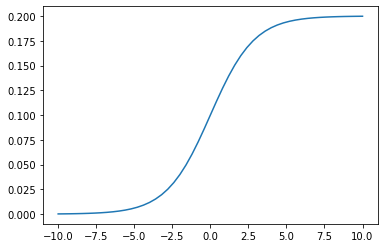

In [1376]:
def fifth_sigmoid(x):
    return 0.2/(1+2**(-x))

x = np.linspace(-10,10,51)
y = fifth_sigmoid(x)
plt.plot(x,y);